### Imports

In [ ]:
!pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for wordcloud from https://files.pythonhosted.org/packages/34/ac/72a4e42e76bf549dfd91791a6b10a9832f046c1d48b5e778be9ec012aa47/wordcloud-1.9.2-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/151.4 kB ? eta -:--:--
   -------- ------------------------------- 30.7/151.4 kB ? eta -:--:--
   ------------------------ --------------- 92.2/151.4 kB 1.3 MB/s eta 0:00:01
   ------------------------------------- -- 143.4/151.4 kB 1.2 MB/s eta 0:00:01
   ---------------------------------------- 151.4/151.4 kB 1.0 MB/s eta 0:00:00


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [ ]:
import numpy as np
import pandas as pd
from textblob import TextBlob
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import string
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,recall_score,precision_score,f1_score
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from wordcloud import WordCloud
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.svm import SVC

import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer


[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading vader_lexicon: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


c:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import getpass
import time

### Web Scrapping

In [ ]:
driver_path=''


In [ ]:
options = webdriver.ChromeOptions()
#All are optional
options.add_experimental_option("detach", True)
options.add_argument("--disable-extensions")
options.add_argument("--disable-notifications")
options.add_argument("--disable-Advertisement")
options.add_argument("--disable-popup-blocking")
options.add_argument("start-maximized")

In [ ]:
service = Service(driver_path)
driver = webdriver.Chrome(options=options,service=service)

In [ ]:
driver.get("https://twitter.com/i/flow/login")


In [ ]:
#Find the Xpath of username to pass username of account
email = ""
username=driver.find_element(By.XPATH,'//*[@id="layers"]/div/div/div/div/div/div/div[2]/div[2]/div/div/div[2]/div[2]/div/div/div/div[5]/label/div/div[2]/div/input')
username.send_keys(email)
time.sleep(4)
username.send_keys(Keys.ENTER)

In [ ]:
#Find the Xpath of password to pass password of account
password=driver.find_element(By.XPATH,'//*[@id="layers"]/div/div/div/div/div/div/div[2]/div[2]/div/div/div[2]/div[2]/div[1]/div/div/div[3]/div/label/div/div[2]/div[1]/input')
password.send_keys(getpass.getpass('Enter your password: '))
time.sleep(2)
password.send_keys(Keys.ENTER)

In [ ]:
tweet_content=list()

In [ ]:
last_position = driver.execute_script("return window.pageYOffset;")
# Scroll down until last position is reached and extract tweets
while True:
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    tweets = driver.find_elements(By.XPATH, '//div[@data-testid="tweetText"]')

    for tweet in tweets:
        tweet_content.append(tweet.text)

    new_position = driver.execute_script("return window.pageYOffset;")
    time.sleep(7)

    if new_position == last_position:
        driver.refresh()

    last_position = new_position
    print(len(tweet_content))

    if len(tweet_content) > 1100:
        break


In [ ]:
df=pd.DataFrame(tweet_content,columns=['Tweets'])
df.to_csv('tweets.csv',index=False)

### Preprocessing and Wrangling

In [ ]:
tweets = pd.read_csv("tweets.csv")

In [ ]:
def get_se_labels(df):
    labels = []
    for text in df["Tweets"]:
        if isinstance(text, str):
            analysis = SentimentIntensityAnalyzer().polarity_scores(text)
            compound_score = analysis["compound"]

            if compound_score is not None:
                labels.append(2 if compound_score >= 0.05 else 0 if compound_score <= -0.05 else 1)
            else:
                labels.append(None)
        else:
            labels.append(None)

    return labels


In [ ]:
tweets["label"] = np.array(get_se_labels(tweets))

In [ ]:
tweets['label'].isnull().sum()
tweets = tweets.dropna()

In [ ]:
def preprocess(df):
    ps = PorterStemmer()
    stop_words = set(stopwords.words('english'))
    tweets = df.to_numpy()[:, 0]
    tweets = [i.strip() for i in tweets]
    tweets = [i.split("\n") for i in tweets]

    for i in range(len(tweets)):
        tweets[i] = [k.split(" ") for k in tweets[i]]
        tweets[i] = [word for sentence in tweets[i] for word in sentence]
        tweets[i] = [''.join(c for c in s if c not in string.punctuation) for s in tweets[i]]
        tweets[i] = [k.lower() for k in tweets[i]]
        tweets[i] = [k for k in tweets[i] if "https" not in k]
        tweets[i] = [s for s in tweets[i] if s not in stop_words]
        tweets[i] = [s for s in tweets[i] if s]
        tweets[i] = [ps.stem(s) for s in tweets[i]]

    df["Tweets"] = tweets


In [ ]:
preprocess(tweets)

### Feature Extraction and Splitting

In [ ]:
X = tweets["Tweets"]
y = tweets["label"].astype(int)

X = X.apply(lambda x: ' '.join(x))


In [ ]:
vectorizer = CountVectorizer(ngram_range=(2, 2))
X_BI = vectorizer.fit_transform(X)
X_BI = X_BI.toarray()

In [ ]:
idf_vectorizer = TfidfVectorizer()
X_TFIDF = idf_vectorizer.fit_transform(X)
X_TFIDF = X_TFIDF.toarray()

### Modelling

#### Splitting

In [ ]:
X_train_BI, X_test_BI, y_train_BI, y_test_BI = train_test_split(X_BI, y, test_size=0.2, random_state=0)
X_train_TFIDF, X_test_TFIDF, y_train_TFIDF, y_test_TFIDF = train_test_split(X_TFIDF, y, test_size=0.2, random_state=0)

y_train_BI_onehot = tf.keras.utils.to_categorical(y_train_BI, num_classes=3)
y_train_TFIDF_onehot = tf.keras.utils.to_categorical(y_train_TFIDF, num_classes=3)

labels = ["Negative","Nuetral", "Positive"]

#### ANN Model

##### Bigrams

In [ ]:
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(X_train_BI.shape[1],)))
model.add(Dense(100, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train_BI,y_train_BI_onehot, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
21/21 [==============================] - 2s 37ms/step - loss: 0.6469 - accuracy: 0.4827 - val_loss: 0.6047 - val_accuracy: 0.4850
Epoch 2/10
21/21 [==============================] - 0s 18ms/step - loss: 0.5112 - accuracy: 0.5985 - val_loss: 0.5064 - val_accuracy: 0.6108
Epoch 3/10
21/21 [==============================] - 0s 18ms/step - loss: 0.3345 - accuracy: 0.8752 - val_loss: 0.4103 - val_accuracy: 0.7425
Epoch 4/10
21/21 [==============================] - 0s 18ms/step - loss: 0.1720 - accuracy: 0.9519 - val_loss: 0.3566 - val_accuracy: 0.7485
Epoch 5/10
21/21 [==============================] - 0s 17ms/step - loss: 0.0822 - accuracy: 0.9820 - val_loss: 0.3406 - val_accuracy: 0.7365
Epoch 6/10
21/21 [==============================] - 0s 19ms/step - loss: 0.0447 - accuracy: 0.9895 - val_loss: 0.3482 - val_accuracy: 0.7425
Epoch 7/10
21/21 [==============================] - 0s 20ms/step - loss: 0.0307 - accuracy: 0.9910 - val_loss: 0.3543 - val_accuracy: 0.7425
Epoch 8/10
21

In [ ]:
y_pred_BI = model.predict(X_test_BI)
y_pred_BI = np.argmax(y_pred_BI, axis=1)

y_train_BI_pred = model.predict(X_train_BI)
y_train_BI_pred = np.argmax(y_train_BI_pred,axis = 1)

accuracy_ANN_BI = accuracy_score(y_test_BI, y_pred_BI)

26/26 [==============================] - 0s 6ms/step


In [ ]:
print("Accuracy of ANN with Bigrams Train: ", accuracy_score(y_train_BI,y_train_BI_pred) * 100)
print("Recall of ANN with Bigrams Train: ", recall_score(y_train_BI, y_train_BI_pred, average='macro') * 100)
print("Precision of ANN with Bigrams Train: ", precision_score(y_train_BI, y_train_BI_pred, average='macro') * 100)
print("F1 Score of ANN with Bigrams Train: ", f1_score(y_train_BI, y_train_BI_pred, average='macro') * 100)

Accuracy of ANN with Bigrams Train:  94.23076923076923
Recall of ANN with Bigrams Train:  92.04370575561711
Precision of ANN with Bigrams Train:  95.53496293885362
F1 Score of ANN with Bigrams Train:  93.42646405585594


In [ ]:
print("Accuracy of ANN with Bigrams Test: ", accuracy_ANN_BI * 100)
print("Recall of ANN with Bigrams Test: ", recall_score(y_test_BI, y_pred_BI, average='macro') * 100)
print("Precision of ANN with Bigrams Test: ", precision_score(y_test_BI, y_pred_BI, average='macro') * 100)
print("F1 Score of ANN with Bigrams Test: ", f1_score(y_test_BI, y_pred_BI, average='macro') * 100)

Accuracy of ANN with Bigrams Test:  78.94736842105263
Recall of ANN with Bigrams Test:  73.1275720164609
Precision of ANN with Bigrams Test:  87.1182768820564
F1 Score of ANN with Bigrams Test:  76.1094043352108


In [ ]:
cm = confusion_matrix(y_train_BI, y_train_BI_pred)

fig = ff.create_annotated_heatmap(cm, x=labels, y=labels, colorscale='Turbo')
fig.update_layout(font=dict(size=15))
fig.update_xaxes(side="bottom")
fig.update_yaxes(side="right")
fig.update_layout(width=600, height=450)
fig.update_layout(title_text="Confusion Matrix (TF-IDF) for ANN model(Train)")
fig.show()


In [ ]:
cm = confusion_matrix(y_test_BI, y_pred_BI)

fig = ff.create_annotated_heatmap(cm, x=labels, y=labels, colorscale='Turbo')
fig.update_layout(font=dict(size=15))
fig.update_xaxes(side="bottom")
fig.update_yaxes(side="right")
fig.update_layout(width=600, height=450)
fig.update_layout(title_text="Confusion Matrix (TF-IDF) for ANN model (Test)")
fig.show()


##### TFIDF

In [ ]:
model = Sequential([
    Dense(100, input_shape=(X_train_TFIDF.shape[1],)),
    Dense(100, activation='relu'),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train_TFIDF, y_train_TFIDF_onehot, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10


21/21 [==============================] - 2s 30ms/step - loss: 0.6608 - accuracy: 0.5669 - val_loss: 0.6230 - val_accuracy: 0.6168
Epoch 2/10
21/21 [==============================] - 0s 15ms/step - loss: 0.5440 - accuracy: 0.8000 - val_loss: 0.5302 - val_accuracy: 0.6707
Epoch 3/10
21/21 [==============================] - 0s 14ms/step - loss: 0.3779 - accuracy: 0.8707 - val_loss: 0.4162 - val_accuracy: 0.7305
Epoch 4/10
21/21 [==============================] - 0s 14ms/step - loss: 0.1982 - accuracy: 0.9353 - val_loss: 0.3414 - val_accuracy: 0.8024
Epoch 5/10
21/21 [==============================] - 0s 14ms/step - loss: 0.0916 - accuracy: 0.9835 - val_loss: 0.3226 - val_accuracy: 0.7964
Epoch 6/10
21/21 [==============================] - 0s 12ms/step - loss: 0.0427 - accuracy: 0.9955 - val_loss: 0.3251 - val_accuracy: 0.8024
Epoch 7/10
21/21 [==============================] - 0s 13ms/step - loss: 0.0219 - accuracy: 0.9985 - val_loss: 0.3397 - val_accuracy: 0.8024
Epoch 8/10
21/21 [======

In [ ]:
y_pred_TFIDF = model.predict(X_test_TFIDF)
y_pred_TFIDF = np.argmax(y_pred_TFIDF, axis=1)

y_pred_TFIDF_train = model.predict(X_train_TFIDF)
y_pred_TFIDF_train = np.argmax(y_pred_TFIDF_train,axis=1)

accuracy_ANN_TFIDF = accuracy_score(y_test_TFIDF, y_pred_TFIDF)


26/26 [==============================] - 0s 4ms/step


In [ ]:
print("Accuracy of ANN with TF-IDF (Train): ", accuracy_score(y_train_TFIDF,y_pred_TFIDF_train) * 100)
print("Recall of ANN with TF-IDF (Train): ", recall_score(y_train_TFIDF,y_pred_TFIDF_train, average='macro') * 100)
print("Precision of ANN with TF-IDF (Train): ", precision_score(y_train_TFIDF,y_pred_TFIDF_train, average='macro') * 100)
print("F1 Score of ANN with TF-IDF (Train): ", f1_score(y_train_TFIDF,y_pred_TFIDF_train, average='macro') * 100)


Accuracy of ANN with TF-IDF (Train):  96.03365384615384
Recall of ANN with TF-IDF (Train):  94.34793600704418
Precision of ANN with TF-IDF (Train):  96.53280271182892
F1 Score of ANN with TF-IDF (Train):  95.33528092766993


In [ ]:
print("Accuracy of ANN with TF-IDF (Test): ", accuracy_ANN_TFIDF * 100)
print("Recall of ANN with TF-IDF (Test): ", recall_score(y_test_TFIDF, y_pred_TFIDF, average='macro') * 100)
print("Precision of ANN with TF-IDF (Test): ", precision_score(y_test_TFIDF, y_pred_TFIDF, average='macro') * 100)
print("F1 Score of ANN with TF-IDF (Test): ", f1_score(y_test_TFIDF, y_pred_TFIDF, average='macro') * 100)


Accuracy of ANN with TF-IDF (Test):  79.42583732057416
Recall of ANN with TF-IDF (Test):  74.03292181069959
Precision of ANN with TF-IDF (Test):  81.20532712159343
F1 Score of ANN with TF-IDF (Test):  75.84543325526933


In [ ]:
cm = confusion_matrix(y_train_TFIDF, y_pred_TFIDF_train)

fig = ff.create_annotated_heatmap(cm, x=labels, y=labels, colorscale='Turbo')
fig.update_layout(font=dict(size=15))
fig.update_xaxes(side="bottom")
fig.update_yaxes(side="right")
fig.update_layout(width=600, height=450)
fig.update_layout(title_text="Confusion Matrix (TF-IDF) for ANN model (Train)")

fig.show()

In [ ]:
cm = confusion_matrix(y_test_TFIDF, y_pred_TFIDF)

fig = ff.create_annotated_heatmap(cm, x=labels, y=labels, colorscale='Turbo')
fig.update_layout(font=dict(size=15))
fig.update_xaxes(side="bottom")
fig.update_yaxes(side="right")
fig.update_layout(width=600, height=450)
fig.update_layout(title_text="Confusion Matrix (TF-IDF) for ANN model (Test)")

fig.show()

### SVM

##### Bigrams

In [ ]:
svm_model = SVC(kernel='linear', C=1, random_state=0)
svm_model.fit(X_train_BI, y_train_BI)


SVC(C=1, kernel='linear', random_state=0)

In [ ]:
y_pred_BI = svm_model.predict(X_test_BI)
accuracy_SVM_BI = accuracy_score(y_test_BI, y_pred_BI)

y_pred_BI_train = svm_model.predict(X_train_BI)

In [ ]:
print("Accuracy of SVM model with Bigram (Train):", accuracy_score(y_train_BI, y_pred_BI_train) * 100, "%")
print("Recall of SVM model with Bigram (Train):", recall_score(y_train_BI, y_pred_BI_train, average='macro') * 100, "%")
print("Precision of SVM model with Bigram (Train):", precision_score(y_train_BI, y_pred_BI_train, average='macro') * 100, "%")
print("F1 Score of SVM model with Bigram (Train):", f1_score(y_train_BI, y_pred_BI_train, average='macro') * 100, "%")

Accuracy of SVM model with Bigram (Train): 99.27884615384616 %
Recall of SVM model with Bigram (Train): 98.80522678306612 %
Precision of SVM model with Bigram (Train): 99.42028985507247 %
F1 Score of SVM model with Bigram (Train): 99.10218923376819 %


In [ ]:
print("Accuracy of SVM model with Bigram (Test):", accuracy_SVM_BI * 100, "%")
print("Recall of SVM model with Bigram (Test):", recall_score(y_test_BI, y_pred_BI, average='macro') * 100, "%")
print("Precision of SVM model with Bigram (Test):", precision_score(y_test_BI, y_pred_BI, average='macro') * 100, "%")
print("F1 Score of SVM model with Bigram (Test):", f1_score(y_test_BI, y_pred_BI, average='macro') * 100, "%")

Accuracy of SVM model with Bigram (Test): 81.3397129186603 %
Recall of SVM model with Bigram (Test): 76.49989170457006 %
Precision of SVM model with Bigram (Test): 89.92248062015503 %
F1 Score of SVM model with Bigram (Test): 79.65945052177436 %


In [ ]:
cm = confusion_matrix(y_train_BI, y_pred_BI_train)

fig = ff.create_annotated_heatmap(cm, x=labels, y=labels, colorscale='Turbo')

fig.update_layout(font=dict(size=15))
fig.update_xaxes(side="bottom")
fig.update_yaxes(side="right")
fig.update_layout(width=600, height=450)
fig.update_layout(title_text="Confusion Matrix (Bigrams) for SVM model (Train)")

fig.show()

In [ ]:
cm = confusion_matrix(y_test_BI, y_pred_BI)

fig = ff.create_annotated_heatmap(cm, x=labels, y=labels, colorscale='Turbo')

fig.update_layout(font=dict(size=15))
fig.update_xaxes(side="bottom")
fig.update_yaxes(side="right")
fig.update_layout(width=600, height=450)
fig.update_layout(title_text="Confusion Matrix (Bigrams) for SVM model (Test)")

fig.show()

##### TFIDF

In [ ]:
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_TFIDF, y_train_TFIDF)

SVC(kernel='linear')

In [ ]:
y_pred_TFIDF = svm_model.predict(X_test_TFIDF)

y_pred_TFIDF_train = svm_model.predict(X_train_TFIDF)

accuracy_SVM_TFIDF = accuracy_score(y_test_TFIDF, y_pred_TFIDF)

In [ ]:
print("Accuracy of SVM model with TF-IDF (Train):", accuracy_score(y_train_TFIDF,y_pred_TFIDF_train) * 100, "%")
print("Recall of SVM model with TF-IDF (Train):", recall_score(y_train_TFIDF,y_pred_TFIDF_train, average='macro') * 100, "%")
print("Precision of SVM model with TF-IDF (Train):", precision_score(y_train_TFIDF,y_pred_TFIDF_train, average='macro') * 100, "%")
print("F1 Score of SVM model with TF-IDF (Train):", f1_score(y_train_TFIDF,y_pred_TFIDF_train, average='macro') * 100, "%")


Accuracy of SVM model with TF-IDF (Train): 99.39903846153845 %
Recall of SVM model with TF-IDF (Train): 99.21194887120414 %
Precision of SVM model with TF-IDF (Train): 99.51754385964912 %
F1 Score of SVM model with TF-IDF (Train): 99.36211268838954 %


In [ ]:
print("Accuracy of SVM model with TF-IDF (Test):", accuracy_SVM_TFIDF * 100, "%")
print("Recall of SVM model with TF-IDF (Test):", recall_score(y_test_TFIDF, y_pred_TFIDF, average='macro') * 100, "%")
print("Precision of SVM model with TF-IDF (Test):", precision_score(y_test_TFIDF, y_pred_TFIDF, average='macro') * 100, "%")
print("F1 Score of SVM model with TF-IDF (Test):", f1_score(y_test_TFIDF, y_pred_TFIDF, average='macro') * 100, "%")



Accuracy of SVM model with TF-IDF (Test): 82.77511961722487 %
Recall of SVM model with TF-IDF (Test): 77.98137318605156 %
Precision of SVM model with TF-IDF (Test): 86.2158189773038 %
F1 Score of SVM model with TF-IDF (Test): 80.3584156399552 %


In [ ]:
cm = confusion_matrix(y_train_TFIDF,y_pred_TFIDF_train)

fig = ff.create_annotated_heatmap(cm, x=labels, y=labels, colorscale='Turbo')

fig.update_layout(font=dict(size=15))
fig.update_xaxes(side="bottom")
fig.update_yaxes(side="right")
fig.update_layout(width=600, height=450)
fig.update_layout(title_text="Confusion Matrix (TF-IDF) for SVM model (Train)")

fig.show()

In [ ]:
cm = confusion_matrix(y_test_TFIDF, y_pred_TFIDF)

fig = ff.create_annotated_heatmap(cm, x=labels, y=labels, colorscale='Turbo')

fig.update_layout(font=dict(size=15))
fig.update_xaxes(side="bottom")
fig.update_yaxes(side="right")
fig.update_layout(width=600, height=450)
fig.update_layout(title_text="Confusion Matrix (TF-IDF) for SVM model (Test)")

fig.show()

### Visualization

In [ ]:
# plot a bar chart of the sentiment distribution and use Positively, Negatively and Neutral as labels
fig = go.Figure([go.Bar(x=labels, y=[len(tweets[tweets["label"] == 0]), len(tweets[tweets["label"] == 1]), len(tweets[tweets["label"] == 2])], text=[len(tweets[tweets["label"] == 0]), len(tweets[tweets["label"] == 1]), len(tweets[tweets["label"] == 2])], textposition='auto', marker_color=['red', 'blue', 'green'])])
fig.update_layout(title_text="Sentiment Distribution")\
.update_layout(width=500,height=450)\
.update_layout(xaxis_title="Sentiment")\
.update_layout(yaxis_title="Count")\
.update_layout(font=dict(size=13))
fig.show()

In [ ]:
models = ['SVM (Bigrams)', 'ANN (Bigrams)', 'SVM (TF-IDF)', 'ANN (TF-IDF)']
accuracy = np.array([accuracy_SVM_BI,accuracy_ANN_BI, accuracy_SVM_TFIDF,  accuracy_ANN_TFIDF]) * 100
colors = np.array(['#FFA500', '#FFA500', '#1E90FF', '#1E90FF'])

# add annotations

accuracy = np.round(accuracy,2)

fig = go.Figure(data=[go.Bar(
    x=models,
    y=np.round(accuracy,2),
    marker_color=colors,
    text=accuracy,
    textposition='auto',
)])
fig.update_layout(title_text='Accuracy of Models')\
    .update_xaxes(title_text='Models')\
    .update_yaxes(title_text='Accuracy (%)')\
    .update_layout(width=800, height=500)


fig.show()

In [ ]:
# plot a grouped bar chart of the precision, recall and f1-score of the models and use Positively, Negatively and Neutral as labels

precision = np.array([precision_score(y_test_BI, y_pred_BI, average='macro'), precision_score(y_test_BI, y_pred_BI, average='macro'), precision_score(y_test_TFIDF, y_pred_TFIDF, average='macro'), precision_score(y_test_TFIDF, y_pred_TFIDF, average='macro')]) * 100
recall = np.array([recall_score(y_test_BI, y_pred_BI, average='macro'), recall_score(y_test_BI, y_pred_BI, average='macro'), recall_score(y_test_TFIDF, y_pred_TFIDF, average='macro'), recall_score(y_test_TFIDF, y_pred_TFIDF, average='macro')]) * 100
f1 = np.array([f1_score(y_test_BI, y_pred_BI, average='macro'), f1_score(y_test_BI, y_pred_BI, average='macro'), f1_score(y_test_TFIDF, y_pred_TFIDF, average='macro'), f1_score(y_test_TFIDF, y_pred_TFIDF, average='macro')]) * 100

fig = go.Figure(data=[
    go.Bar(name='Precision', x=models, y=np.round(precision,2), marker_color='#FFA500', text=np.round(precision,2), textposition='auto'),
    go.Bar(name='Recall', x=models, y=np.round(recall,2), marker_color='#1E90FF', text=np.round(recall,2), textposition='auto'),
    go.Bar(name='F1-Score', x=models, y=np.round(f1,2), marker_color='#FF0000', text=np.round(f1,2), textposition='auto')
])

fig.update_layout(barmode='group', title_text='Precision, Recall and F1-Score of Models')\
    .update_xaxes(title_text='Models')\
    .update_yaxes(title_text='Metrics (%)')\
    .update_layout(width=850, height=500)
fig.show()



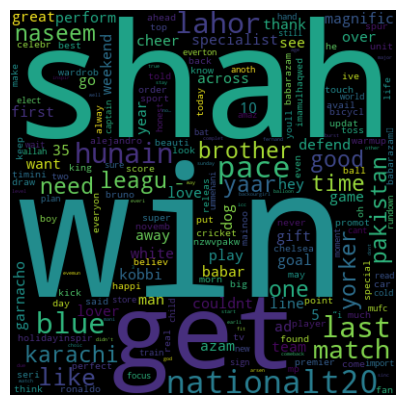

In [ ]:
positive_tweets = tweets[tweets['label'] == 2]
positive_tweets = positive_tweets['Tweets'].to_list()

word_count = {}
for item in positive_tweets:
    for word in item:
        word_count[word] = word_count.get(word, 0) + 1

wordcloud = WordCloud(width=400,height=400).generate_from_frequencies(word_count)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

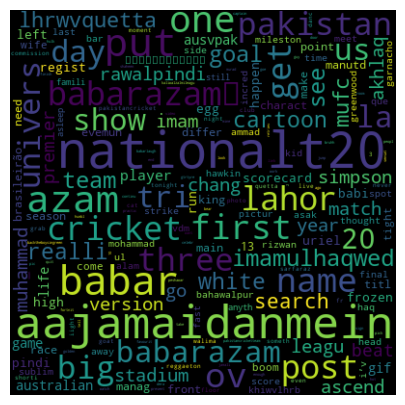

In [ ]:
nuetral_tweets = tweets[tweets['label'] == 1]
nuetral_tweets = nuetral_tweets['Tweets'].to_list()

word_count = {}
for item in nuetral_tweets:
    for word in item:
        word_count[word] = word_count.get(word, 0) + 1

wordcloud = WordCloud(width=400,height=400).generate_from_frequencies(word_count)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

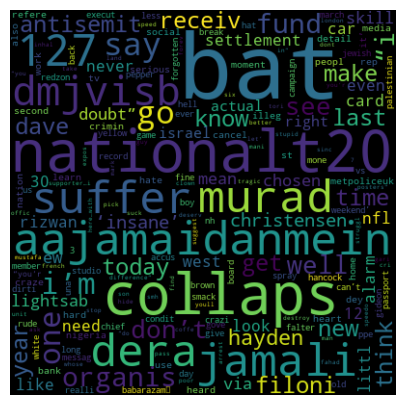

In [ ]:
negative_tweets = tweets[tweets['label'] == 0]
negative_tweets = negative_tweets['Tweets'].to_list()

word_count = {}
for item in negative_tweets:
    for word in item:
        word_count[word] = word_count.get(word, 0) + 1

wordcloud = WordCloud(width=400,height=400).generate_from_frequencies(word_count)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()